# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Цель выполнения работы: выяснить влияет ли новый шрифт на поведение пользователей

План выполнения работы:
1) Откройть файл с данными и изучить общую информацию

2) Подготовить данные

* заменить название заголовков на более удобные
* проверить данные на пропуски и некорректный тип данных
* добавить столбец даты и времени, а также отдельный столбец дат

3) Изучить данные

* найти сколько всего событий и пользователей в логе
* сколько приходится событий в среднем на одного пользователя
* определить период анализа данных

4) изучение воронки событий

* подсчитать сколько пользователей совершили то или иное действие
* найти самое распростаненное действие среди пользователей
* предположить в каком порядке происходит воронка 
* расчитать процент потери пользователей на последнем этапе относительно первого

5) изучить результаты эксперимента

* расчет статитстической значимости результатов A/A теста
* расчет статистической значимости результатов A/B теста

6) выводы по результатам работы

# Описание данных
Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Открытие файла с данными

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from scipy import stats as st
import math as mth

In [77]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проанализировали изначальные данные в датафрейме, пропусков не обнаруженно. Однако, заметим, что нужно привести столбец EventTimestamp в корректный тип данных

### Подготовка данных к работе

In [78]:
data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'], unit='s')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [79]:
data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [80]:
data.duplicated().sum()

413

В данных присутствуют явные дубликаты

In [81]:
print(round(data.duplicated().sum()/data.shape[0]*100,2), '%')

0.17 %


Доля дубликатов всего лишь 0.17% можно смело убирать из анализа

In [82]:
data.drop_duplicates(inplace=True)

In [83]:
data['date'] = data['event_timestamp'].dt.date
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Добавили столбец с датой события по дням

Промежуточный вывод: изменили вид столбцов на змеиный регистр, проверили данные на пропуски и исключили их, привели столбец event_timesstamp в корректный тип данных, добавили новый столбец date с датами по дням

### Изучить данные

In [84]:
data['device_id_hash'].nunique()

7551

всего в датафрейме у нас 7551 уникальный пользователь

In [85]:
(data.groupby('device_id_hash')['exp_id'].nunique() > 1).sum()

0

В каждой группе теста присутсвуют только уникальные пользователи. Хороший знак, так как смешение пользователей из разных групп могло повлиять на результаты теста

In [86]:
data['event_name'].count()

243713

Всего записано 243713 событий которые сделали пользователи

In [87]:
round(data['event_name'].count() / data['device_id_hash'].nunique(),2)

32.28

В среднем на одного пользователя приходится 32 события

In [88]:
print('Минимальная дата ', data['date'].min(), ' максимальная дата ', data['date'].max())
print('Разница ', data['date'].max() - data['date'].min())

Минимальная дата  2019-07-25  максимальная дата  2019-08-07
Разница  13 days, 0:00:00


Определили период теста - 13 дней. Начался 25 июля 2019 года и закончился 7 августа 2019 года

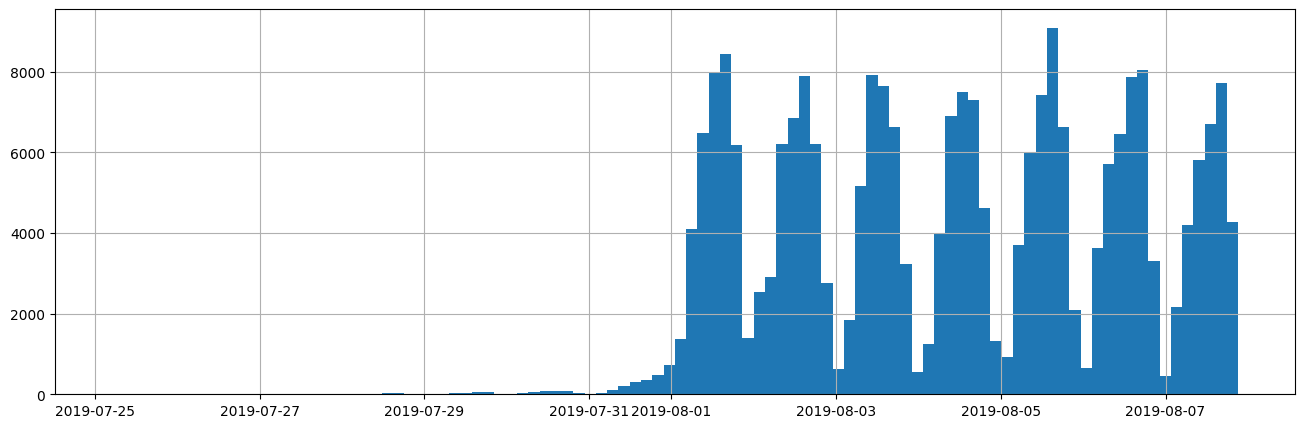

In [89]:
data['event_timestamp'].hist(figsize=(16,5), bins=100)
plt.show()

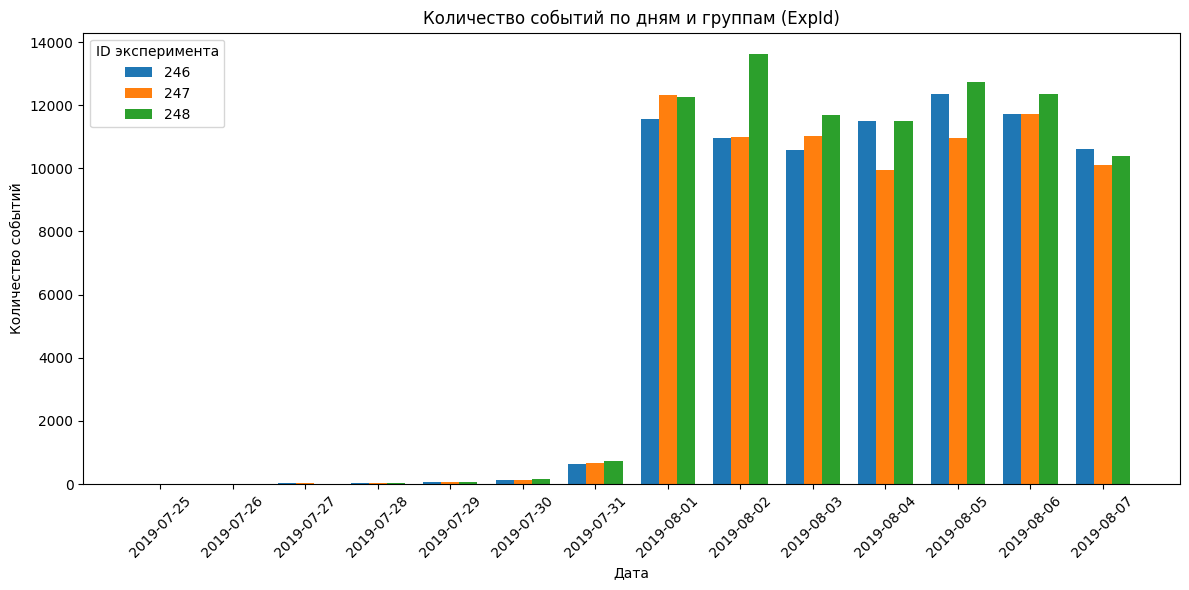

In [90]:
events_per_day = data.groupby(['date', 'exp_id']).size().unstack(fill_value=0)

# Даты и эксперименты
dates = events_per_day.index
exp_ids = events_per_day.columns

# Параметры графика
x = np.arange(len(dates))  # координаты по оси X
width = 0.25  # ширина столбцов

# Создаем фигуру
fig, ax = plt.subplots(figsize=(12, 6))

# Построение столбцов для каждого ExpId
for i, exp_id in enumerate(exp_ids):
    ax.bar(x + i * width, events_per_day[exp_id], width, label=f'{exp_id}')

# Настройка осей
ax.set_xlabel('Дата')
ax.set_ylabel('Количество событий')
ax.set_title('Количество событий по дням и группам (ExpId)')
ax.set_xticks(x + width)
ax.set_xticklabels(dates, rotation=45)
ax.legend(title='ID эксперимента')

# Показываем график
plt.tight_layout()
plt.show()

При построении графика распределения данных по времени сделаем вывод, что имеются неполные данные примерно до начала августа. Анализировать их не имеет смысла так как они могут исказить результаты. Распределения по группам примерно одинаковые

In [91]:
complete_data = data[data['date'] >=  date(2019, 8, 1)]

print('события до корректировки', data.shape[0],
      'пользователи до корректировки', data['device_id_hash'].nunique())
print('события после корректировки ', data.shape[0] - complete_data.shape[0],
      'пользователи после корректировки',
      data['device_id_hash'].nunique() - complete_data['device_id_hash'].nunique())
print('Абсолютные потери событий', complete_data.shape[0],
      'Абсолютные потери пользователей ',complete_data['device_id_hash'].nunique())
print('Утечка данных событий',
      round(complete_data.shape[0]/data.shape[0]*100-100, 2), '%',
      'Утечка данных пользователей',
      round(complete_data['device_id_hash']
            .nunique()/data['device_id_hash'].nunique()*100-100, 2), '%')

события до корректировки 243713 пользователи до корректировки 7551
события после корректировки  2826 пользователи после корректировки 17
Абсолютные потери событий 240887 Абсолютные потери пользователей  7534
Утечка данных событий -1.16 % Утечка данных пользователей -0.23 %


За точку отсечения примем 1 августа 2019 года. Утечка данных при удалении данных составить 1.16%. Вполне допустимо, даже с учетом удаления дубликатов утечка не превышает 1.5%. Делаем вывод о исключении данных из анализа

In [92]:
incomplete_data = data[data['date'] <  date(2019, 8, 1)]
data.drop(index=incomplete_data.index, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [93]:
data['exp_id'].unique()

array([246, 247, 248], dtype=int64)

Видим, что присутствуют пользователи всех групп

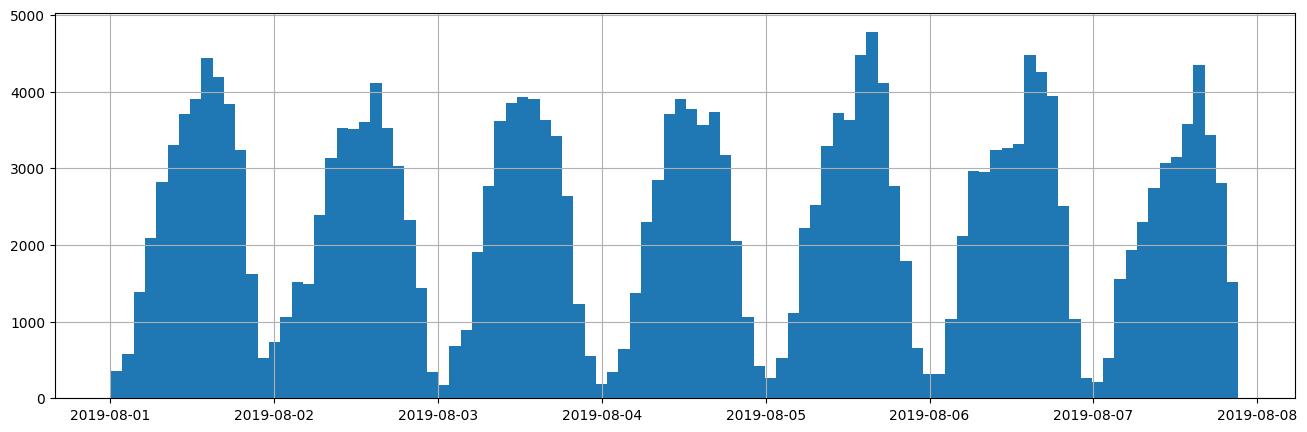

In [94]:
data['event_timestamp'].hist(figsize=(16,5), bins=100)
plt.show()

Из графика видно, что теперь время периода анализа занимает 7 дней, а график имеет явно повторяющуюся форму очевидно связанную с распределением активности пользователей каждый день на сайте

In [95]:
data.groupby('event_name')['device_id_hash'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: device_id_hash, dtype: int64

Из таблицы сделаем вывод, что чаще всего совершалось такое действие как просмотр главного экрана 117 328 раз, а меньше всего прохождение обучения 1005 раз

In [96]:
funnel = (data.groupby('event_name')['device_id_hash']
          .nunique().sort_values(ascending=False).reset_index())
funnel.columns = ['event_name', 'count']
funnel['percent'] = round(funnel['count']/data['device_id_hash'].nunique()*100,2)
funnel

,event_name,count,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Аналогичная ситуация и с конкретными пользователями, чаще всего просматривали главный экран 7419 пользователей, а меньше всего проходили обучение всего 840 пользователей. Имеет смысл исключить событие обучение, так как оно не связано с воронкой пользователей на прямую 

In [97]:
funnel.drop(index=4, inplace=True)

In [98]:
funnel['percentage'] = round(funnel['count'].div(funnel['count'].shift(1)).fillna(1) * 100,2)
funnel

,event_name,count,percent,percentage
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


При подсчете воронке событий мы выяснили, что наиболее высокая просадка при переходе на следующий этап у нас идет на шаге показ предложения товара. Потеря с предыдущим шагом состовляет примерно 38%. Также отметим что после показа корзины пользователи в 94.78% случаев переходили на оплату товара

In [99]:
round(funnel.loc[3, 'count'] / funnel.loc[0, 'count'] * 100, 2)

47.7

Только 47.7 % пользователей посетивших сайт оплатили товар

Промежуточный вывод: мы нашли количество пользователей и событий в логе. Проанализировали сколько в среднем приходится событий на пользователя. По графику событий увидели, что данные до 1 августа не полные и удалили ненужные данные из анализа. Обновленный период анализа составил 7 дней. Также проанализировали воронку событий, выяснили что самое популярное событие это показ главного экрана, а самое редкое это обучение. Составли воронку событий в которой нашли, что больше всего пользователей уходят на моменте перехода с главного экрана на экран показа товара. Также сделали вывод, что только 47.7% пользователей дошли до оплаты товара

### Изучить результаты теста

In [100]:
trials = data.groupby('exp_id')['device_id_hash'].nunique().reset_index().reset_index(drop=True)
trials.columns = ['group', 'users']
trials

,group,users
0,246,2484
1,247,2513
2,248,2537


In [101]:
successes = (data.pivot_table(index = 'exp_id',
                 columns = 'event_name',
                 values = 'device_id_hash',
                 aggfunc = 'nunique').reset_index())


successes

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


Создадим две группы - trials (количество пользователей в каждой группе) и successes (количество пользователей выполнивших определенное действие по каждой группе)

В А/A и в A/B тестировании мы проверяем равны ли доли выборок между собой, для проверки статистической значимости используем Z-критерий (статистический тест, позволяющий определить, различаются ли два средних значения генеральной совокупности, когда дисперсии известны и размер выборки велик). Для удобства, напишем функцию

Сформируем 2 гипотезы:

H0 - доли выборок равны

H1 - между  долями выборок есть статистически обоснованное различие

In [102]:
def z_test(trials, successes):
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

Напишем функцию которая считает p_value между двуми группами

In [103]:
def z_test_conclusion(p_value):
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print('\t')

Напишем функцию сравнения, которая сверяет p_value с уровнем статистической значимости alpha равный 0.01

In [104]:
alpha = 0.01 
p_value = z_test(trials['users'].drop(index=2),successes['PaymentScreenSuccessful'].drop(index=2))

In [105]:
z_test_conclusion(p_value)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	


Исходя из результатов вызванной функции сделаем вывод, что нет основания считать различие между группами 246 и 247 статистически значимым, так как p_value > 0.01

Исходя из предыдущих вычислений мы узнали что самым популярным событием является просмотр главного экрана

In [106]:
successes['MainScreenAppear']

0    2450
1    2476
2    2493
Name: MainScreenAppear, dtype: int64

В среднем просмотр главного экрана выполнело примерно одинаковое количество пользователей в каждой из групп

In [107]:
round(successes['MainScreenAppear']/trials['users'] * 100)

0    99.0
1    99.0
2    98.0
dtype: float64

Практически 100% пользователей выполнили просмотр главного экрана в каждой из групп

In [108]:
successes.drop(columns=['exp_id', 'PaymentScreenSuccessful'], index=2)

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,Tutorial
0,1266,2450,1542,278
1,1238,2476,1520,283


In [109]:
alpha = 0.05
test = successes.drop(columns=['exp_id', 'PaymentScreenSuccessful'], index=2)
for name in test.columns:
    p_value = z_test(trials['users'].drop(index=2),test[name])
    print('Для ',name)
    z_test_conclusion(p_value)

Для  CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	


Для всех событий отличие между группами 246 и 247 не является статистически значимым, так как p_value каждого события выше уровня статистической значимости 0.05

In [110]:
for i in range(2):
    trial = trials.drop(index=i)
    succ = successes.drop(index=i)
    print('Для групп', list(succ['exp_id']))
    succ = succ.drop(columns=['exp_id'])
    for name in succ.columns:
        p_value = z_test(trial['users'].reset_index(drop=True),succ[name].reset_index(drop=True))
        print('Для ',name)
        z_test_conclusion(p_value)
    print('')

Для групп [247, 248]
Для  CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	

Для групп [246, 248]
Для  CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  OffersScreenA

Сравним анологично группы 246 и 247 с группой 248, где был заменен шрифт сайта. Также по итогам эксперимента не видим обнаруженной статистической значимости между событиями из разных групп

In [111]:
row_united = successes.loc[0] + successes.loc[1]

# Преобразуем row_united в DataFrame с правильной структурой
row_united_df = pd.DataFrame([row_united])

successes_united = pd.concat([successes, row_united_df], ignore_index=True)
successes_united.iloc[-1, 0] = '246_247'  # Используем -1 для обращения к последней строке
successes_united

C:\Users\Admin\AppData\Local\Temp\ipykernel_24652\262163615.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '246_247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  successes_united.iloc[-1, 0] = '246_247'  # Используем -1 для обращения к последней строке


event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279
3,246_247,2504,4926,3062,2358,561


In [112]:
row_united = trials.loc[0] + trials.loc[1]

# Создаем DataFrame из объединенной строки
row_united_df = pd.DataFrame([row_united], columns=trials.columns)

# Объединяем с исходным DataFrame
trials_united = pd.concat([trials, row_united_df], ignore_index=True)

# Меняем значение в первой колонке последней строки
trials_united.iloc[-1, 0] = '246_247'

trials_united

C:\Users\Admin\AppData\Local\Temp\ipykernel_24652\1269005918.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '246_247' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trials_united.iloc[-1, 0] = '246_247'


,group,users
0,246,2484
1,247,2513
2,248,2537
3,246_247,4997


Посчитаем статистическое различие между объединенными группами 246 и 247 и группой 248, для этого добавим новую строку в датафреймы trials и successes, где добавим объединенный результат групп 246 и 247

In [113]:
print('Для объединенной группы 246_247 сравнение с группой 248')
print('\t')
for name in successes_united.drop(columns=['exp_id']).columns:
    p_value = z_test(trials_united.drop(index=[0,1]).reset_index(drop=True)['users'],
                    successes_united.drop(index=[0,1], columns=['exp_id']).reset_index(drop=True)[name])
    print('Для ',name)
    z_test_conclusion(p_value)

Для объединенной группы 246_247 сравнение с группой 248
	
Для  CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	
Для  Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
	


Также не была выявлена какая либо статистическая значимость у объединенной группы 246 и 247 с группой 248 из-за p_value событий ниже порога alpha 0.05

Можно сделать вывод о том, что изменение шрифта на всем сайте никак не изменило поведение клиентов не по одному из приведенных выше событий. 

Так как у нас присутствует A/A тест, то порог alpha должен быть ниже, в районе 1%, если предполагается, что сравниваются группы без примененных изменений. Для других тестов A/B применим стандартный уровень aplha 5%. Поправка на множественный тест не требуется так как p_value значительно превышает alpha, так что в данном случае корректировкой можно принебречь

### Выводы по итогу работы

По итогу работы, данные были очищены от дубликатов, отсеяны неполные данные мешающие анализу. Установленный горизонт анализа 7 дней, с 1 по 8 августа 2019 года. Всего принимали участие в анализе 3 группы: 246 группа, 247 группа участники A/A теста и 248 группа участник A/B теста. Всего 7534 пользователей и 240 тысяч событий.

Предположили, что воронка событий состоит из: открытия главной страницы (MainScreenAppear), выбора товаров(OffersScreenAppear), показа товара в корзине(CartScreenAppear), экрана оплаты(PaymentScreenSuccessful). Этап обучения (tutorial) не связан этапно с воронкой

При подсчете воронке мы выделили просадку пользователей после шага просмотра главного экрана и показа товара, на этом этапе примерно теряется 38% пользователей. Также всего лишь 5.3% пользователей не доходят до оплаты после того как положили свой товар в корзину. Всего дошли примерно 47.7% пользователей от начала воронки до конца.

Для анализа A/B теста нашли количество уникальных пользователей в каждой из групп.
Всего в в 246 группе 2484 уникальных пользователей, в 247 группе 2513 уникальных пользователей, в 248 группе 2537 уникальных пользователей. 
Самым популярным событием является просмотр главного экрана. Также по результатам работы сравнили контрольные группы 246 и 247 в который не было примененных нововеденний. По результатам проверки, различие между группами не было статистически обосновано. Также были сравнили группы 246 и 247 с группой 248 к которой были применены измененения шрифта, статистических различий между контрольными группами и группой с изменениями выявлено не было. Также проверили совмещенные группы 246 и 247 на различие с группой 248 по итогам которого различий также выявлено не было.

По итогам работы можно сделать следующие выводы - измененный шрифт в приложении никак не влияет на поведение потребителя, если такие изменения требуют затрат, то лучше оставить шрифт таким же. 

